In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.models import Sequential
from keras_tuner import HyperModel
from keras_tuner import RandomSearch, Objective
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(45)

# Generate the sequence
num_samples = 1000  # Number of samples
start_value = 0     # Starting value of the sequence
difference = 2*np.pi/1000    # Difference between adjacent values
noise_level = 5   # Standard deviation of Gaussian noise

# Generate the sequence with uniform differences
X_train = np.arange(start_value, start_value + num_samples * difference, difference)

# Generate the corresponding target values (e.g., sine function with noise)
y_train = X_train+10*np.sin(X_train) + np.random.normal(0, noise_level, num_samples)

In [ ]:
np.random.seed(43)

# Generate the sequence
num_samples = 200  # Number of samples
start_value = 0     # Starting value of the sequence
difference = 2*np.pi/200    # Difference between adjacent values
noise_level = 5   # Standard deviation of Gaussian noise

# Generate the sequence with uniform differences
X_val = np.arange(start_value, start_value + num_samples * difference, difference)

# Generate the corresponding target values (e.g., sine function with noise)
y_val = X_val+10*np.sin(X_val) + np.random.normal(0, noise_level, num_samples)

In [ ]:
# Define the custom loss function with smoothness penalty
def smoothness_loss(y_true, y_pred, lambda_smooth, threshold):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Compute the differences between consecutive predictions
    y_pred_diff = y_pred[1:] - y_pred[:-1]

    # Apply the threshold to the differences
    penalty_mask = tf.abs(y_pred_diff) > threshold

    # Compute the smoothness penalty term considering the threshold
    smoothness_penalty = tf.reduce_sum(tf.square(y_pred_diff) * tf.cast(penalty_mask, tf.float32))

    # Total loss
    total_loss = mse_loss + lambda_smooth * smoothness_penalty

    return total_loss

# Create a custom loss wrapper
def get_custom_loss(lambda_smooth, threshold):
    def custom_loss(y_true, y_pred):
        return smoothness_loss(y_true, y_pred, lambda_smooth, threshold)
    return custom_loss

# Define the Keras model inside a HyperModel class
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential([
            Dense(256, activation=LeakyReLU(alpha=0.2), input_shape=(1,)),
            Dense(128, activation=LeakyReLU(alpha=0.2)),
            Dense(64, activation=LeakyReLU(alpha=0.2)),
            Dense(32, activation=LeakyReLU(alpha=0.2)),
            Dense(16, activation=LeakyReLU(alpha=0.2)),
            Dense(8, activation=LeakyReLU(alpha=0.2)),
            Dense(4, activation=LeakyReLU(alpha=0.2)),
            Dense(2, activation=LeakyReLU(alpha=0.2)),
            Dense(1)
        ])

        lambda_smooth = hp.Float('lambda_smooth', 1e-5, 1e-1)
        threshold = hp.Float('threshold', 0.1, 10)

        model.compile(optimizer='adam', loss=get_custom_loss(lambda_smooth, threshold))
        return model

# Instantiate the HyperModel
hypermodel = MyHyperModel()

# Instantiate the tuner and perform hyperparameter search
tuner = RandomSearch(
    hypermodel,
    objective=Objective('val_loss', direction='min'),
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

# Define early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Prepare your data
# Assuming X_train, y_train, X_val, y_val are already defined

# Run the hyperparameter search
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=100,
             callbacks=[early_stopping_callback])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best lambda_smooth: {best_hps.get("lambda_smooth")}')
print(f'Best threshold: {best_hps.get("threshold")}')


Trial 10 Complete [00h 00m 14s]
val_loss: 25.262357711791992

Best val_loss So Far: 25.086610794067383
Total elapsed time: 00h 02m 10s
Best lambda_smooth: 0.0005221263170660316
Best threshold: 0.5312530241709924


In [ ]:
np.random.seed(47)

# Generate the sequence
num_samples = 200  # Number of samples
start_value = 0     # Starting value of the sequence
difference = 2*np.pi/200    # Difference between adjacent values
noise_level = 5   # Standard deviation of Gaussian noise

# Generate the sequence with uniform differences
X_test = np.arange(start_value, start_value + num_samples * difference, difference)

# Generate the corresponding target values (e.g., sine function with noise)
y_test = X_test+10*np.sin(X_test) + np.random.normal(0, noise_level, num_samples)

7/7 [==============================] - 0s 2ms/step


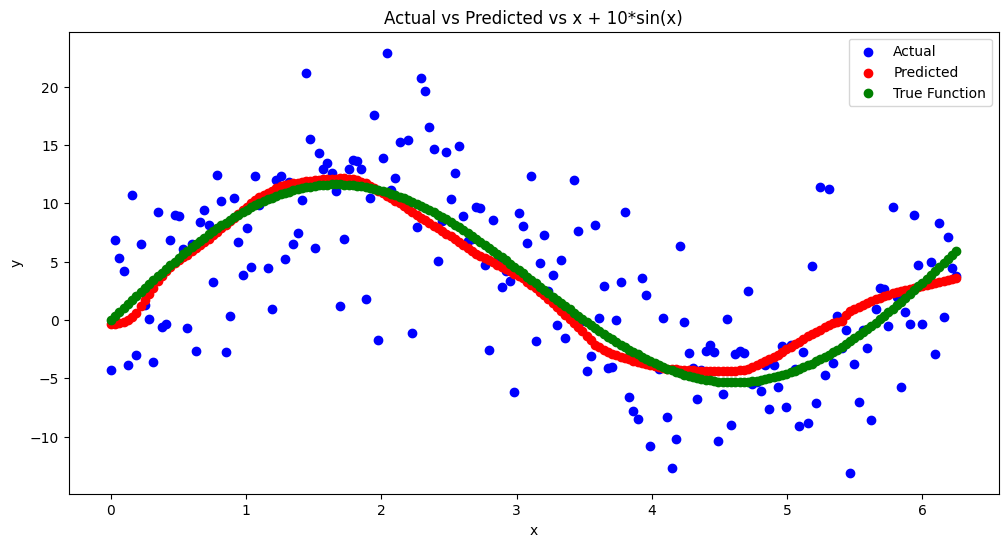

Mean Squared Error 62.878668779496465


In [ ]:
# Predict on the test data
y_pred = best_model.predict(X_test)

# Calculate the true values for the function e^x + 10*sin(x)
y_true = X_test + 10 * np.sin(X_test)

# Plot the actual vs predicted values and the true function
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.scatter(X_test, y_true, color='green', label='True Function')
plt.title('Actual vs Predicted vs x + 10*sin(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

mse = np.mean((y_true - y_pred) ** 2)
print("Mean Squared Error", mse)